# Reference https://github.com/olof98johansson/StockPrediction

In [2]:
import torch
import torch.nn as nna
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Dataset 전처리

In [3]:
stock = 'Data/AMZN.csv'
df = pd.read_csv(stock)
df = df.set_index('Date')
df["Company stock name"] = stock.split('/')[-1].split('.')[0]

df.head()

,Open,High,Low,Close,Adj Close,Volume,Company stock name
Date,,,,,,,
2011-01-12,185.360001,185.380005,183.300003,184.080002,184.080002,2679100,AMZN
2011-01-13,183.600006,186.449997,183.509995,185.529999,185.529999,3367000,AMZN
2011-01-14,185.500000,188.940002,184.919998,188.750000,188.750000,3662800,AMZN
2011-01-18,188.660004,191.600006,188.250000,191.250000,191.250000,3896200,AMZN
2011-01-19,190.899994,191.000000,186.210007,186.869995,186.869995,3882400,AMZN


### 각 Column 의미

high : 고가  
Low : 저가  
Open : 시가  
Close : 종가  
Volume : 거래량  
Adj Close : 수정종가(분할, 배당, 배분, 신주 발생이 된 경우를 고려해 주식 가격을 조정해둔 가격)

# Processing datasets

In [4]:
# next data closing price 추가
df["Next_day_closing_price"] = df["Close"].shift(-1).dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,Company stock name,Next_day_closing_price
Date,,,,,,,,
2011-01-12,185.360001,185.380005,183.300003,184.080002,184.080002,2679100,AMZN,185.529999
2011-01-13,183.600006,186.449997,183.509995,185.529999,185.529999,3367000,AMZN,188.750000
2011-01-14,185.500000,188.940002,184.919998,188.750000,188.750000,3662800,AMZN,191.250000
2011-01-18,188.660004,191.600006,188.250000,191.250000,191.250000,3896200,AMZN,186.869995
2011-01-19,190.899994,191.000000,186.210007,186.869995,186.869995,3882400,AMZN,181.960007


In [5]:
df["Actual"] = df["Next_day_closing_price"]
df.head()

,Open,High,Low,Close,Adj Close,Volume,Company stock name,Next_day_closing_price,Actual
Date,,,,,,,,,
2011-01-12,185.360001,185.380005,183.300003,184.080002,184.080002,2679100,AMZN,185.529999,185.529999
2011-01-13,183.600006,186.449997,183.509995,185.529999,185.529999,3367000,AMZN,188.750000,188.750000
2011-01-14,185.500000,188.940002,184.919998,188.750000,188.750000,3662800,AMZN,191.250000,191.250000
2011-01-18,188.660004,191.600006,188.250000,191.250000,191.250000,3896200,AMZN,186.869995,186.869995
2011-01-19,190.899994,191.000000,186.210007,186.869995,186.869995,3882400,AMZN,181.960007,181.960007


In [8]:
x_df = df[["Close", "Open", "High", "Low", "Volume"]].dropna()[:-1]
y_df = df["Next_day_closing_price"].dropna().fillna(0)

In [9]:
x_df.head()

,Close,Open,High,Low,Volume
Date,,,,,
2011-01-12,184.080002,185.360001,185.380005,183.300003,2679100
2011-01-13,185.529999,183.600006,186.449997,183.509995,3367000
2011-01-14,188.750000,185.500000,188.940002,184.919998,3662800
2011-01-18,191.250000,188.660004,191.600006,188.250000,3896200
2011-01-19,186.869995,190.899994,191.000000,186.210007,3882400


In [10]:
y_df.head()

Date
2011-01-12    185.529999
2011-01-13    188.750000
2011-01-14    191.250000
2011-01-18    186.869995
2011-01-19    181.960007
Name: Next_day_closing_price, dtype: float64

In [11]:
# 다양한 주식 indicator 관련 함수 선언


# 수익률
def daily_return(df):
    # 수익률 = (매도가격-매수가격)/매수가격
    df['Daily_returns'] = df['Close'].pct_change(1).fillna(0)
    return df

def roc_indicator(df: pd.DataFrame):
    # Computes rate of change (RoC), i.e momentum - percent change
    # ROC(Price Rate Of Change)-과거 일정 시점의 가격대비 현재 주가의 변동률
    # 0부터 시작, 시장 가격이 상승추세인 경우 ROC는 0보다 큰값
    # 하락 추세인 경우 ROC는 0미만의 값, 즉 음수를 가짐
    # ROC = ((금일 종가 - N일전 종가) / N일 전 종가) * 100
    df["RoC"] = df['Close'].diff() / df['Close'][:-1]
    return df

def williams_r(df: pd.DataFrame, lookback: int):
    # Computes Williams %R that measures overbought and oversold levels
    # 자산의 과매수/과매도 수준을 측정하기 위한 탄력 지표
    # %R = (highest(H,period)-C)/(highest(H,period)-lowest(L,period)) * (-100)
    # 산출기간의 표준은 14일이다. 즉, period=14
    wr = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            wr[t_idx] = 0
        else:
            highest = np.max(df['High'][t_idx-lookback:t_idx].values)
            lowest = np.min(df['Low'][t_idx-lookback:t_idx].values)
            wr[t_idx] = (highest - df['Close'][t_idx]) / (highest - lowest)
    df["williams_r"] = wr
    return df

def money_flow_index(df: pd.DataFrame, period: int):
    # Measures buying and selling pressure (if below 20 then buy if above 80 then sell)
    # 주식(혹은 증권)의 가격과 거래량을 사용하여 주식이 과잉 매도인지 과잉 매수인지 식별하기
    # 위한 기술적 지표
    # 수식은 검색
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow, negative_flow = [], []
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            positive_flow.append(0)
            negative_flow.append(money_flow[i-1])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_mf = [sum(positive_flow[i + 1 - period:i + 1]) for i in range(period-1, len(positive_flow))]
    negative_mf = [sum(negative_flow[i + 1 - period:i + 1]) for i in range(period - 1, len(negative_flow))]
    idx = 0
    mfi = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= period:
            mfi[t_idx] = 0
        else:
            mfi[t_idx] = 100 * (positive_mf[idx] / (positive_mf[idx] + negative_mf[idx]))
            idx += 1
    df["MFI"] = mfi
    return df

### VOLATILITY INDICATORS ###
def ulcer_index(df: pd.DataFrame, lookback: int):
    # Measures downside risk in terms of depth and duration of price declines
    # measures downside risk in terms of both the depth and duration of price declines
    # The index increases in value as the price moves farther away from a recent high and falls as the price rises to new highs.
    # The indicator is usually calculated over a 14-day period, with the Ulcer Index showing the percentage drawdown a trader can expect from the high over that period.
    # 수식은 검색
    ui = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            ui[t_idx] = 0
        else:
            maxprice = np.max(df['Close'][t_idx-lookback:t_idx].values)
            percentage_drawdown = [(df['Close'][t_idx-i]-maxprice)/maxprice * 100 for i in reversed(range(lookback))]
            ulcer_ind = np.sqrt(np.sum(np.array(percentage_drawdown)**2) / lookback)
            ui[t_idx] = ulcer_ind
    df['Ulcer_index'] = ui
    return df

def average_true_range(df: pd.DataFrame, lookback: int):
    # Measures market volatility
    # 시간에 따른 주가의 변동성
    # 수식은 검색
    av_tr_rang = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            av_tr_rang[t_idx] = 0
        else:
            true_ranges = []
            for idx in reversed(range(lookback)):
                tr1 = df['High'][t_idx-idx] - df['Low'][t_idx-idx]
                tr2 = np.abs(df['High'][t_idx-idx] - df['Close'][t_idx-idx])
                tr3 = np.abs(df['Low'][t_idx-idx] - df['Close'][t_idx-idx])
                true_ranges.append(np.max([tr1, tr2, tr3]))
            atr = sum(true_ranges) / lookback
            av_tr_rang[t_idx] = atr
    df['ATR'] = av_tr_rang
    return df

def simple_moving_average(df: pd.DataFrame, windows: list):
    # 일정기간동안 가격의 평균
    for window in windows:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean().fillna(0)
    return df

def exponential_moving_average(df: pd.DataFrame, windows: list):
    # 최신 데이터에 더 많은 가중치를 계산하는 이동평균
    for window in windows:
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean().fillna(0)
    return df

def get_indicators(df: pd.DataFrame):
    df = daily_return(df)
    df = roc_indicator(df)
    df = williams_r(df, 14)
    df = money_flow_index(df, 14)
    df = ulcer_index(df, 14)
    df = average_true_range(df, 14)
    df = simple_moving_average(df, [5, 10, 20])
    df = exponential_moving_average(df, [20, 50])
    return df    

In [12]:
# indicator 추가
x_processed_df = get_indicators(x_df).fillna(0)

In [13]:
x_processed_df.head()

,Close,Open,High,Low,Volume,Daily_returns,RoC,williams_r,MFI,Ulcer_index,ATR,SMA_5,SMA_10,SMA_20,EMA_20,EMA_50
Date,,,,,,,,,,,,,,,,
2011-01-12,184.080002,185.360001,185.380005,183.300003,2679100,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,184.080002,184.080002
2011-01-13,185.529999,183.600006,186.449997,183.509995,3367000,0.007877,0.007815,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,184.218097,184.136865
2011-01-14,188.750000,185.500000,188.940002,184.919998,3662800,0.017356,0.017060,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,184.649707,184.317772
2011-01-18,191.250000,188.660004,191.600006,188.250000,3896200,0.013245,0.013072,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,185.278306,184.589624
2011-01-19,186.869995,190.899994,191.000000,186.210007,3882400,-0.022902,-0.023439,0.0,0.0,0.0,0.0,187.295999,0.0,0.0,185.429896,184.679050


In [15]:
# 데이터 전처리 세부내역
stationary = False 
scale = False

In [16]:
# making data stationary

def get_stationary_data(df:pd.DataFrame, columns:list, diff:int):
    # Making the data stationary
    df_cp = df.copy()
    for col in columns:
        df_cp[str(col)] = pd.DataFrame(np.log(df_cp[str(col)]).diff().diff(diff))
    return df_cp

if stationary:
    for col in x_processed_df.columns:
        x_processed_df = get_stationary_data(x_processed_df, [col], 12)
    
    y_df = get_stationary_data(df, ["Next_day_closing_price"], 12)['Next_day_closing_price']
    y_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

x_processed_df.replace([np.inf, -np.inf], 0, inplace=True)

In [17]:
####### data scaling(If you want)

x_data_values = x_processed_df.fillna(0).values[:-1]
y_data_values = y_df.values[:-1].reshape(-1, 1)

x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

if scale:
    x_data = x_scaler.fit_transform(x_data_values)
    y_data = y_scaler.fit_transform(y_data_values)
else:
    x_data = x_data_values
    y_data = y_data_values

In [18]:
####### split data #######
train_split_ratio = 0.8
time_period=30

# train datasets
train_data_size = int(np.ceil(len(x_data) * train_split_ratio))
x_train_data = x_data[:train_data_size]
y_train_data = y_data[:train_data_size]

# example
# x_train_data = [1,2,3,4,5,6,7]
# time_period = 3
# => x_train = [[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7]]
# => y_train = [[4]    ,[5]    , [6],   [7],   ,.....]
x_train = [x_train_data[i-time_period:i] for i in range(time_period, len(x_train_data))]
y_train = y_train_data[time_period:]

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

# test datasets
x_test_data = x_data[train_data_size - time_period:]
y_test = y_data[train_data_size:]
x_test = [x_test_data[i-time_period:i] for i in range(time_period, len(x_test_data))]

x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [19]:
x_processed_df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Daily_returns', 'RoC',
       'williams_r', 'MFI', 'Ulcer_index', 'ATR', 'SMA_5', 'SMA_10', 'SMA_20',
       'EMA_20', 'EMA_50'],
      dtype='object')

# 학습 모델 선언

In [20]:
class transf_params:
    n_layers = 11
    num_heads = 16
    model_dim = 16  # nr of features
    forward_dim = 2048
    output_dim = 1
    dropout = 0
    n_epochs = 200
    lr = 0.01
    
class CustomTransformerModel(nn.Module):
    '''
    Transformer model that combines the encoder and the decoder
    "model_dim" must be the same size as "num_features" in the input data (i.e size last dimension),
    otherwise freely tunable parameters
    '''

    def __init__(self, n_layers=6, model_dim=512, output_dim=512,
                 num_heads=6, forward_dim=2048, dropout=0.2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.linear = nn.Linear(16, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        enc_out = self.encoder(X)
        #flat = self.flatten(enc_out)
        out = self.relu(self.linear(enc_out[:, -1, :]))
        return out
    
class StockForecastingModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.transf = CustomTransformerModel(n_layers=params.n_layers,
                                             num_heads=params.num_heads,
                                             model_dim=params.model_dim,
                                             forward_dim=params.forward_dim,
                                             output_dim=16,
                                             dropout=params.dropout)
        self.linear = nn.Linear(16, params.output_dim)

    def forward(self, x):
        transf_out = self.transf(x)
        out = self.linear(transf_out)
        return out
model = StockForecastingModel(transf_params)

# 모델 학습

In [22]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=transf_params.lr)

In [23]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

In [24]:
hist = np.zeros(transf_params.n_epochs) # loss값 저장
model.train()
model = model.cuda()

# input값 gpu사용을 위한 설정
x_train, y_train, x_test, y_test = (t.cuda() for t in (x_train, y_train, x_test, y_test))

for epoch in range(transf_params.n_epochs):
    pos = getPositionEncoding(*x_train.shape[1:], n=10000)
    pos = torch.FloatTensor(pos).cuda()
    y_train_pred = model(x_train+pos)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch: {epoch+1}/{transf_params.n_epochs}\tMSE loss: {loss.item():.5f}')
    hist[epoch] = loss.item()

Epoch: 1/200	MSE loss: 726568.06250
Epoch: 51/200	MSE loss: 601525.25000
Epoch: 101/200	MSE loss: 276242.34375
Epoch: 151/200	MSE loss: 276153.25000


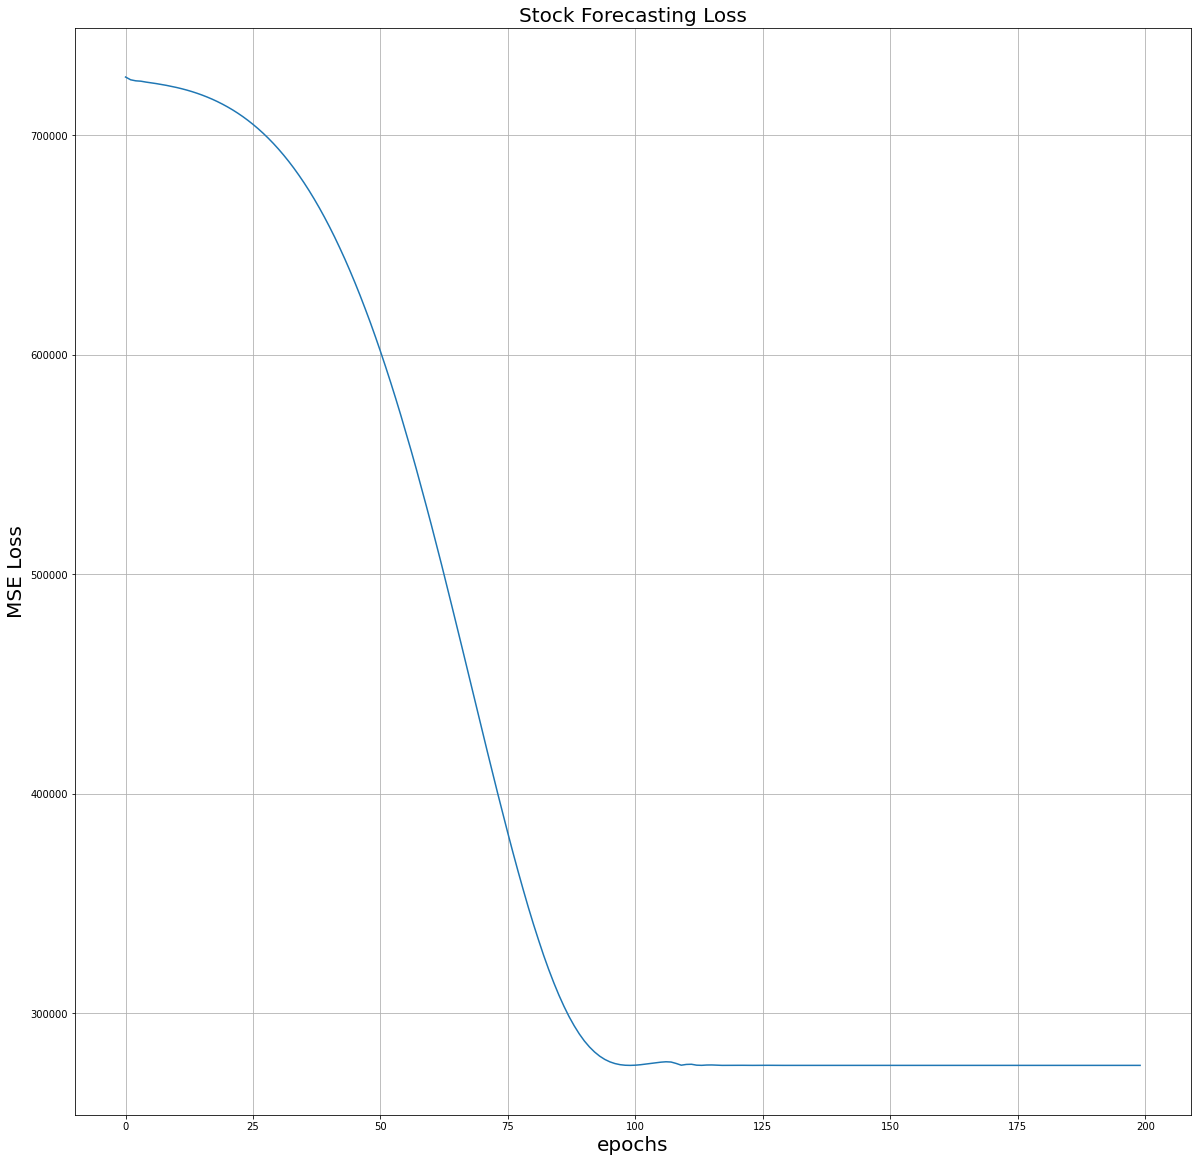

In [25]:
plt.figure(figsize=(20,20))
plt.plot(list(range(transf_params.n_epochs)), hist)
plt.grid()
plt.xlabel("epochs", fontsize=20)
plt.ylabel("MSE Loss", fontsize=20)
plt.title("Stock Forecasting Loss", fontsize=20)
plt.show()

# 학습 결과 확인

In [26]:
model.eval()
with torch.no_grad():
    predictions = model(x_test)

In [27]:
predictions = pd.DataFrame(predictions.detach().cpu().numpy())
predictions.reset_index(drop=True, inplace=True)
predictions.index = df.index[-len(x_test):]
predictions['Actual'] = y_test.detach().cpu().numpy()
# predictions['Actual'] = y_test.detach().cpu().numpy()[:-1]
predictions.rename(columns={0: 'Predictions'}, inplace=True)

In [28]:
# inverse stationary
def inverse_stationary_data(old_df:pd.DataFrame, new_df: pd.DataFrame, orig_feature: str,
                            new_feature: str, diff: int, do_orig=True):
    # Inverse the stationary data transformation

    if do_orig:
        new_df[orig_feature] += np.log(old_df[orig_feature]).shift(1)
        new_df[orig_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
        new_df[orig_feature] = np.exp(new_df[orig_feature])
    new_df[new_feature] += np.log(old_df[orig_feature]).shift(1)
    new_df[new_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
    new_df[new_feature] = np.exp(new_df[new_feature])
    return new_df

if stationary:
    predictions = inverse_stationary_data(old_df=df, 
                                          new_df=predictions, 
                                          orig_feature='Actual', new_feature='Predictions',
                                          diff=12, do_orig=False)

# 최종결과 확인

In [29]:
train = df[:train_data_size]
valid = df[train_data_size:][:-2]
valid['Predictions'] = predictions['Predictions'].values

In [30]:
x_train = [str(train.index[i]).split()[0] for i in range(len(train))]
x_val = [str(valid.index[i]).split()[0] for i in range(len(valid))]

In [31]:
colors = ['#579BF5', '#C694F6', '#F168F1']
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=x_train, y=train['Close'], mode='lines', line_color=colors[0], line_width=2,
               name='Training data'))

fig.add_trace(
    go.Scatter(x=x_val, y=valid['Close'], mode='lines', line_color=colors[1], line_width=2,
               name='Validation data'))

fig.add_trace(
    go.Scatter(x=x_val, y=valid['Predictions'], mode='lines', line_color=colors[2], line_width=2,
               name='Predictions'))

fig.update_layout(showlegend=True)
fig.update_layout(title=dict(text=f'Predictions of stock "{train["Company stock name"][0]}" from {x_val[0]} to {x_val[len(valid) - 1]}',
                             xanchor='auto'),
                  xaxis=go.layout.XAxis(
                      title=go.layout.xaxis.Title(
                          text="Date")),
                  yaxis=go.layout.YAxis(
                      title=go.layout.yaxis.Title(
                          text="Adjusted closing price USD ($)"))
                  )

fig.show()

# 입력값 - 주식데이터
# Label - 다음날 종가(Next day Closing Price)


# 현재까지 결론
1. 모델이 학습되지 않는 문제. 또다른 예시([Reference](https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6)에서도 주식의 이동평균은 예측 가능하지만 Close는 되지 않음. 
2. 데이터 전처리에 많은 시간 소요 - 다양한 주식 Indicator 사용

# Problem?
1. Transformer 모델은 사전학습(Pretrained)를 기반으로 만들어짐
2. Transformer는 대화 모델에 주로 사용됨
3. 주식같은 Time Series 데이터는 외부요인에 의한 변동이 큼 - Stationary : 시간이 변해도 일정한 분포를 따르는 경우 <=> non-stationary : 시간이 변해도 일정한 분포를 따르지 않는 경우

# Time series Forcasting Model-Temporal Fusion Transformers(https://arxiv.org/abs/1912.09363)

![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbX08Yv%2Fbtq4OsSUmLc%2FwfrgYLSkHYMlQQjvrhSeWK%2Fimg.png)

![stock_prediction_paper](./TFT_stock.png)

* DeepAR - LSTM base Encoder/Deocder(Amazon)
* CovTrans - Convolution 기반 transformer
* Seq2Seq - LSTM base Encoder/Decoder
* MQRNN - LSTM + MLP
* TFT - LSTM + MultiHeadAttention

*아직까지 forcasting 은 RNN 기반 모델 성능이 좋음*

# 진행해야 할 일
1. Time Series Forcasting 모델에 대해 전반적인 조사(Transformer 구조뿐만 아니라 기존에 사용되던 모델에 대한 전반적인 조사 필요) + 주식 데이터 전처리 어떻게 했는가!!
2. 주식 데이터 전처리 - 데이터 일부분(종가만 사용 or 선별한 indicator) or 전체를 사용할지 판단. scaling, normalize 이 필요한가 판단. 파라미터 변환하면서 실험
3. Seq2Seq 모델 학습 진행. 학습 진행하면서 1,2, 진행

우선순위 3 >>>>> 1>2